# Rotterdam stylized case

In [1]:
from classes import *
import copy
from collections import OrderedDict
import csv
import numpy as np
import matplotlib.pyplot as plt
import os
#import ipywidgets as widgets
#import pickle

# Set-up the model

### Available damage curves

In [2]:
#From Excel Huizinga et al. (2017) JRC Global flood-depth damage function Excel - tab MaxDamage-residential
#2010 price levels, The Netherlands
MaxDamage_Residential = { 
    'Building_based' : { 'Structure' : 561,  'Content' : 281,    'Total' : 842}, #euro/m2
    'Land-use_based' : 168, #euro/m2
    'Object_based' : 84175 }#euro/house? 

#Tab Damage functions DamCurve_Residential_buildings
depth = [0,0.5,1,1.5,2,3,4,5,6] #depth in meter
dam_frac = [0,0.25,0.4,0.5,0.6,0.75,0.85,0.95,1.00] #damage fraction (-)

dam_pars= (MaxDamage_Residential['Land-use_based'],depth,dam_frac) #all parameters for the damage assessment

### Built model components (dikes and residential areas)

In [3]:
Rotty = Model('Rotty') #Initiate the model class

#Add residential areas to the model
Rotty.add_ResidentialArea(ResidentialArea("Area_A",4,1*1,dam_pars,["No"],"Residential area A: the Heijplaat"))
Rotty.add_ResidentialArea(ResidentialArea("Area_B",1,5*5,dam_pars,["Dike"],"Residential area B: City Centre"))

#Add flood protection objections to the model
Rotty.add_FloodProtection(FloodProtection("No",4,False,"Region without flood protection"))
Rotty.add_FloodProtection(FloodProtection("Dike",4.5,False,"Sea dike"))

<img src="overview.png">

### Set model parameters

In [4]:
Rotty.add_Parameter("alarming_conditions",
       OrderedDict({ #water depth above flood protection level, Name of event, reduction of trust if this happens.
                1   : ['Major flood',40], 
                0   : ['Small flood',20],
                -0.2   : ['Near miss',10],
                -0.4  : ['Major wake-up',7],
                -1  : ['Minor wake-up',5],
                -10  : ['Nothing happens',0]}))

Rotty.add_Parameter("Gumbel", #From Sterl et al. 2009
        OrderedDict({ #parameter for the Gumbel distribution
              "mu"   : 2.33,
              "beta" : 0.234}))

#Rotty.add_Parameter("Trust",
#        OrderedDict({
#              "k" : 0.2,
#              "T_eq" : 70 }))
#global pars (for the development of Trust)
k = 0.2 
T_eq = 70

In [5]:
#Check the model object result
Rotty

Rotty 
-----------
allFloodProtection: 
No 4; Dike 4.5;  
-----------
allResidentialArea: 
Area_A Protected by:['No']
Area_B Protected by:['Dike']

Parameters : 
{'alarming_conditions': OrderedDict([(1, ['Major flood', 40]), (0, ['Small flood', 20]), (-0.2, ['Near miss', 10]), (-0.4, ['Major wake-up', 7]), (-1, ['Minor wake-up', 5]), (-10, ['Nothing happens', 0])]), 'Gumbel': OrderedDict([('mu', 2.33), ('beta', 0.234)])}

### Load storm surge scenarios

In [6]:
SurgeSeries_A = SurgeSeries(allSurgeSeries,"A",'Scenario A: lower part of RCP4.5',None,None) #Je kunt allSurgeSeries ook gewoon bijhouden in de classes.py
SurgeSeries_B = SurgeSeries(allSurgeSeries,"B",'Scenario B: middle of RCP4.5',None,None)
SurgeSeries_C = SurgeSeries(allSurgeSeries,"C",'Scenario C: middle of RCP8.5',None,None)
SurgeSeries_D = SurgeSeries(allSurgeSeries,"D",'Scenario D: upper part of RCP8.5',None,None)
SurgeSeries_A.from_csv("A.csv")
SurgeSeries_B.from_csv("B.csv")
SurgeSeries_C.from_csv("C.csv")
SurgeSeries_D.from_csv("D.csv")

In [7]:
#TODO: MOVE THIS TO CLASSES.PY

allTrendSeries = []

class TrendSeries:
    def __init__(self,name):
        self.name = name
        allTrendSeries.append(self)

    def from_csv(self,filename):
        filename = os.path.join("SurgeSeries",filename)
        years = []
        surgelevel = []
        with open(filename) as f:
            reader = csv.reader(f)
            for row in reader:
                years.append(row[0])
                surgelevel.append(row[1])
        self.years = [int(i) for i in years]
        self.surgelevel = [float(i) for i in surgelevel] #convert strings to floats

TrendSeries_A = TrendSeries("A")
TrendSeries_A.from_csv("A_trend.csv")
TrendSeries_B = TrendSeries("B")
TrendSeries_B.from_csv("B_trend.csv")
TrendSeries_C = TrendSeries("C")
TrendSeries_C.from_csv("C_trend.csv")
TrendSeries_D = TrendSeries("D")
TrendSeries_D.from_csv("D_trend.csv")

# Define adaptation strategies (Mayors)

In [8]:
small = Measure_FloodProtection("Minor Dike Heightening", 7, 0.5)
large = Measure_FloodProtection("Major Dike Heightening", 12, 1)


class Kroket(Mayor):
    """
    Reactive management strategy:
    In case of near miss: implements a Small dike heightening
    In case of a flood event: implements a Large dike heightening
    
    """
    def get_name(self):
        return('Berry Kroket')
    
    def apply_strategy(self,Model,SurgeSeries,i,time):
        
        #STRATEGY FOR THE OUTERDIKE AREA
        #TODO
        
        #STRATEGY FOR THE CITY CENTRE
        CC = Model.allResidentialArea[1]
        FP = Model.allFloodProtection[1] #the object to which to apply the heightening
        
        if CC.event_impact_history[i] == 10:
            #print('Small measure triggered')
            #check if there are already measures planned
            newmeasure = copy.deepcopy(small) #make a copy of the measure to implement
            
            lst = [Measure for Measure in allactiveMeasure if Measure.apply_to.name == FP.name]
            #list is either empty or has an active object
            if len(lst) != 0: #if there is an active measure
                Measure_inprogress = lst[0]
                #IN THIS CASE WE DON'T NEED TO CHECK FURTHER! 
                #BECAUSE THIS IS THE SMALLEST MEASURE, 
                #AN EXISTING MEASURE WILL ALWAYS BE THE SAME OR LARGER THAN THE NEW IDEA!
            else: #there are no active measures
                newmeasure.plan_measure(FP,i)
            
        if CC.event_impact_history[i] > 10:
            #print('Large measure triggered')
            #check if there are already measures planned
            newmeasure = copy.deepcopy(large) #make a copy of the measure to implement
            
            lst = [Measure for Measure in allactiveMeasure if Measure.apply_to.name == FP.name]
            #list is either empty or has an active object
            if len(lst) != 0: #if there is an active measure
                measure_inprogress = lst[0]
                if newmeasure.heightening > measure_inprogress.heightening: #the new plan is larger than the old one
                    #print('Er was al een plan, maar het nieuwe is radicaler!!!')
                    allactiveMeasure.remove(measure_inprogress) #remove the old measure from the active measure list
                    newmeasure.lead_time = newmeasure.lead_time - 5 #you can implement the new plan faster!
                    newmeasure.plan_measure(FP,i)
                    #print(allactiveMeasure)
   
            else: #there are no active measures
                newmeasure.plan_measure(FP,i)
    
class Bob(Mayor):
    """
    Proactive management strategy:
    In case of a minor wake-up: implements Small dike heightening
    In case of a flood event: implements Large dike heightening
    """
    pass

class Economicus(Mayor):
    """
    Management strategy on the basis of a cost-benefit ration
    
    """
    
    def get_name(self):
        return('Mr. H. Economicus')

    def apply_strategy(self,Model,SurgeSeries,i,time):
        
        #STRATEGY FOR THE CITY CENTRE
        CC = Model.allResidentialArea[1]
        FP = Model.allFloodProtection[1] #the object to which to apply the heightening

        if 5 <= CC.risk[i] < 10: #If the flood risk in the City Centre exceeds X mln euro per year
            newmeasure = copy.deepcopy(small) #make a copy of the measure to implement    
            lst = [Measure for Measure in allactiveMeasure if Measure.apply_to.name == FP.name]
            #list is either empty or has an active object
            if len(lst) != 0: #if there is an active measure
                Measure_inprogress = lst[0]
                #IN THIS CASE WE DON'T NEED TO CHECK FURTHER! 
                #BECAUSE THIS IS THE SMALLEST MEASURE, 
                #AN EXISTING MEASURE WILL ALWAYS BE THE SAME OR LARGER THAN THE NEW IDEA!
            else: #there are no active measures
                newmeasure.plan_measure(FP,i)

        elif CC.risk[i] >= 10: #If the flood risk in the City Centre exceeds X mln euro per year
            newmeasure = copy.deepcopy(large) #make a copy of the measure to implement
            
            lst = [Measure for Measure in allactiveMeasure if Measure.apply_to.name == FP.name]
            #list is either empty or has an active object
            if len(lst) != 0: #if there is an active measure
                measure_inprogress = lst[0]
                if newmeasure.heightening > measure_inprogress.heightening: #the new plan is larger than the old one
                    #print('Er was al een plan, maar het nieuwe is radicaler!!!')
                    allactiveMeasure.remove(measure_inprogress) #remove the old measure from the active measure list
                    newmeasure.lead_time = newmeasure.lead_time - 5 #you can implement the new plan faster!
                    newmeasure.plan_measure(FP,i)
                    #print(allactiveMeasure)
   
            else: #there are no active measures
                newmeasure.plan_measure(FP,i)
        
        
        
class Lawkeeper(Mayor):
    """
    Management strategy in which the protection should meet formal requirements
    
    """
    
    def get_name(self):
        return('Servant Lawkeeper') 
    pass

    
allMayors = [Economicus]

In [9]:
def run_model(Model,SurgeSeries,Mayor):
    time = SurgeSeries.years
    
    #REMOVE ALL ACTIVE MEASURES FROM PREVIOUS RUNS
    allactiveMeasure.clear()
    
    #GET MODEL PARAMETERS
    alarming_conditions = Model.Parameters['alarming_conditions']
    
    #TODO ADD THIS FUNCTIONALITY TO THE FLOODPROTECTIONCLASS
    for FloodProtection in Model.allFloodProtection:
        FloodProtection.init_time(time)             

    for Area in Model.allResidentialArea:
        Area.match_with_FloodProtection(Model.allFloodProtection) #ADD THE INFORMATION OF THE FLOOD PROTECTION STRUCTURES TO THE AREAS IT PROTECTS
        Area.init_time(time) #create all the variables that are manipulated over time

    # THE MODEL RUNS OVER A YEARLY TIMESTEP
    for i,t in enumerate(time): #Iterate over the years t, with index i
        #print(i,t, end=" |")
        
        for Area in Model.allResidentialArea:
            #FIRST EVALUATE IF THE FLOOD PROTECTION LEVEL IS EXCEEDED (TO DETERMINE IF FLOOD HAPPENS)
            if Area.protection_level[i] < SurgeSeries.surgelevel[i]: #if a flood occurs
                Area.flood_history[i] = SurgeSeries.surgelevel[i] - Area.elevation
                #print("Prot. lvl = {}, Surge lvl = {}, Elev = {}, Inund = {}".format(Area.protection_level[i],
                 #                                         SurgeSeries.surgelevel[i],
                 #                                         Area.elevation,
                  #                                        Area.flood_history[i]             
                   #                ))
                #print("{} is inundated with a water depth of {} m \n --> damage occurs".format(Area.name,Area.flood_history[i]))
                Area.flood_damage[i] = Area.calculate_damage(Area.flood_history[i])
                #print("Damage is calculated at: {} euro".format(dam))
                
            #THEN EVALUATE THE IMPACT ON TRUST
            if i != 0: #don't evaluate trust in the first timestep!
                #print(Area.protection_level-levels_t[i])
                Area.event_impact_history[i] = evaluate_event(SurgeSeries.surgelevel[i]-Area.protection_level[i],alarming_conditions,False)
                #First evaluate the impact of this year's event (if any)

                Area.trust_t[i] = Area.trust_t[i-1] - Area.event_impact_history[i]

                #ALWAYS MODEL RECOVERY OF TRUST
                dTdt = (Area.trust_t[i]-T_eq)*-k
                Area.trust_t[i] = Area.trust_t[i] + dTdt

        #CALCULATE THE OBJECTIVE RISK

        #Find the SLR trend series that belongs to this storm surge series
        for TS in allTrendSeries: #TODO: THIS CAN BE AVOIDED BY BETTER ORGANIZING THE INPUT SURGE LEVELS
            if TS.name == SurgeSeries.name: #ALSO IN THIS FORM, THIS CAN ALREADY BE MOVED UP
                relevant_TS = TS

        for RA in Model.allResidentialArea:
            mu = Model.Parameters["Gumbel"]["mu"]
            beta = Model.Parameters["Gumbel"]["beta"]
            SLR = relevant_TS.surgelevel[i] #todo change name to SLR to avoid confusion!!
            max_surge = RA.protection_level[i]-SLR #the maximum storm surge level this dike can cope with
            RA.protection_level_rp[i] = Gumbel_RP(max_surge,mu,beta) #Return period of the flood protection level
            RPs = [10000,5000,2000,1000,500,200,100,50,20,10,5,2]
            damages = []
            for RP in RPs:
                #Expected water levels are the sum of the Gumbel distributed WLs 
                waterlevel = Gumbel_inverse(RP,mu,beta) + SLR
                inundation = waterlevel - RA.elevation
                damages.append(RA.calculate_damage(inundation)) #damage assuming no FPL
            RA.risk[i] = risk_FP(damages.copy(),RPs,RA.protection_level_rp[i])*10**(-6) #EAD in million 2010-euro's 
            #print(RA.risk)
            #print(RA.protection_level_rp)
                
        #IMPLEMENT FLOOD PROTECTION MEASURES
        Mayor.apply_strategy(Model,SurgeSeries,i,time)
        for measure in allactiveMeasure: #tell all measures that are currently planned that a timestep has passed and that their implementation is coming near 
            measure.countdown(i,len(time)) #we need to tell the measure instances which timestep it is
        
        for Area in Model.allResidentialArea: #kan naar hierboven! als method van measure
               Area.match_with_FloodProtection(Model.allFloodProtection)
    
    #RETURN OUTCOMES OF THE MODEL
    experiment = OrderedDict({
        "model_name" : Model.name,
        "Model" : copy.deepcopy(Model),
        "SurgeSeries" : copy.deepcopy(SurgeSeries),
        "Mayor" : copy.deepcopy(Mayor)
    })
    
    return experiment

experiments = []
for SurgeSeries in allSurgeSeries:
    #print("\n \n {} \n\n------------- \n\n".format(SurgeSeries.name))
    experiment = run_model(Rotty,SurgeSeries,Economicus())
    experiments.append(experiment)
print('experiments finished')

experiments finished


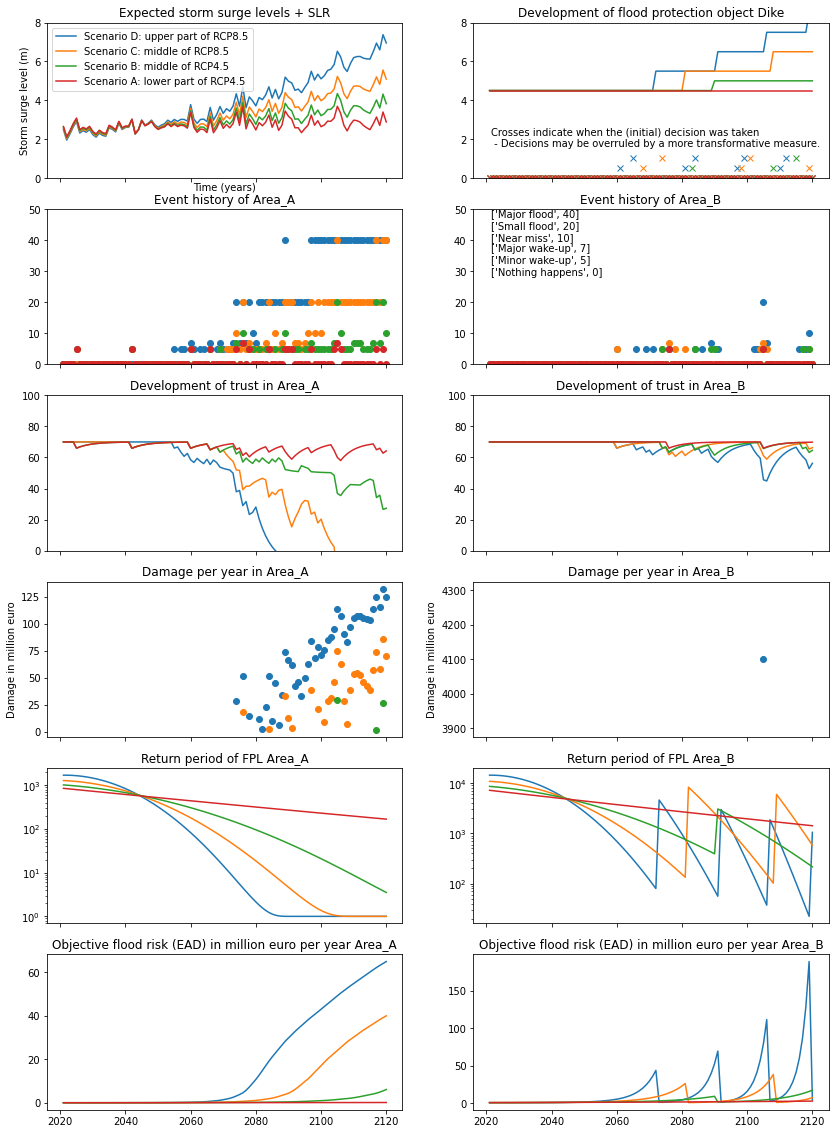

In [10]:
fig, axes = plt.subplots(nrows=6,ncols=2,sharey=False,sharex=True,figsize=(14,20))

labels = []

for experiment in reversed(experiments):
    
    Model = experiment['Model']
    SurgeSeries = experiment['SurgeSeries']
    Mayor = experiment['Mayor']
    
    #print(SurgeSeries.name)
    
    axes[0,0].plot(SurgeSeries.years,SurgeSeries.surgelevel)

    labels.append(SurgeSeries.description)
    axes[0,0].set_title('Expected storm surge levels + SLR')
    axes[0,0].set_xlabel('Time (years)')
    axes[0,0].set_ylabel('Storm surge level (m)')
    axes[0,0].set_ylim(0,8)
    axes[0,1].set_ylim(0,8)

    for i, Area in enumerate(Model.allResidentialArea):
        axes[1,i].set_title('Event history of {}'.format(Area.name))
        axes[1,i].plot(SurgeSeries.years,Model.allResidentialArea[i].event_impact_history,'o')
        axes[1,i].set_ylim(0,50)
        
        axes[2,i].set_title('Development of trust in {}'.format(Area.name))
        axes[2,i].plot(SurgeSeries.years,Model.allResidentialArea[i].trust_t)

        axes[2,i].set_ylim(0,100)
        
        #plot damage
        axes[3,i].set_title('Damage per year in {}'.format(Area.name))
        axes[3,i].plot(SurgeSeries.years,[x*10**(-6) for x in Model.allResidentialArea[i].flood_damage],'o')
    
        axes[4,i].set_title('Return period of FPL {}'.format(Model.allResidentialArea[i].name))
        axes[4,i].plot(SurgeSeries.years,Model.allResidentialArea[i].protection_level_rp,'-')
        axes[4,i].set_yscale("log")
        #axes[1,i].set_ylim(0,50)
    
        axes[5,i].set_title('Objective flood risk (EAD) in million euro per year {}'.format(Model.allResidentialArea[i].name))
        axes[5,i].plot(SurgeSeries.years,Model.allResidentialArea[i].risk,'-')
        #axes[1,i].set_yscale("log")
        #axes[1,i].set_ylim(0,50)
    
    axes[0,1].plot(SurgeSeries.years,Model.allFloodProtection[1].protection_level)
    axes[0,1].set_title('Development of flood protection object Dike')
    
axes[0,0].legend(labels)

axes[3,0].set_ylabel('Damage in million euro')
axes[3,1].set_ylabel('Damage in million euro')

#Add some additional text to some axes
alarming_conditions = Model.Parameters['alarming_conditions']

textbox = ""
for key in alarming_conditions:
    textbox = textbox + str(alarming_conditions[key]) + '\n'

axes[0,1].text(0.05,0.2,"Crosses indicate when the (initial) decision was taken \n - Decisions may be overruled by a more transformative measure.",transform=axes[0,1].transAxes)
axes[1,1].text(0.05,0.5,textbox,transform=axes[1,1].transAxes)


axes[0,1].set_prop_cycle(None) #reset the cycler to plot again in the same axes with similar colors
for experiment in reversed(experiments):
    Model = experiment['Model']
    SurgeSeries = experiment['SurgeSeries']
    Mayor = experiment['Mayor']    
    
    axes[0,1].plot(SurgeSeries.years,Model.allFloodProtection[1].measure_history,'x') #PLOT THE HISTORY OF THE MEASURES
    


In [11]:
fig.savefig('Economicus.png')